Time per sample/timestep: 0.0167
Samples per second: 60.00
Counts per timestep (sample): 1
Total Samples/Timesteps: 313999
Total time of Data Collection: 5233.3 s


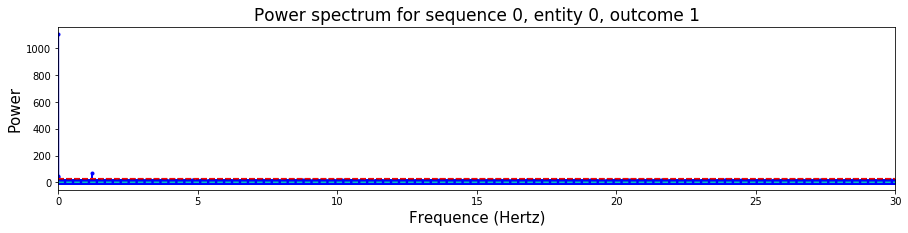

#1 Frequency: 0.0001 Hz
#2 Frequency: 1.2076 Hz
#3 Frequency: 0.0009 Hz
#4 Frequency: 0.0003 Hz
#5 Frequency: 17.8435 Hz
Highest frequency tested is 30.000 Hz


In [23]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data, gate_string_to_list
from drift_file_io import drift_input, calculate_average_timestep, merge_lines
savepath = None

save = True
data_option = 3
###############file io (option 2) is for each line being one sample, merge (opt. 3) is to combine all lines into one sample
###########################################Manipulate variables here ###############################################
#################################################################################################################
#For reading in experimental data: enter here
if data_option == 2 or data_option == 3:
    base = "N:/Programs/Ions Share/Gate-Set Tomography/DriftAnalysis/" 
    name = '2018_08_27 Gi Data/2018_08_27_1354_31_DRIFT' #specify date_folder/txt_file_name
    file_loc = base + name + ".txt"
    time_per_sample = 1/60 #seconds, only necessary if you're doing the merge lines
    savepath = None
    if save and (data_option == 2 or data_option == 3):
        savepath = base  + name + "_Merged_Bitstring_Plot.png"
##################################################################################################################
##############################################################################################################
#Don't change anything below this line for regular program operation

#initialize arrays
ones_count_array = []
zeros_count_array = []
timestamp_array = [] #time in seconds
probs_array = []
raw_bit_array = []

#load arrays based on choice of simulation or experimental input
#calculate timestep (per sample) for simulated data, extract avg from experimental data
if data_option == 2:
    raw_bit_array, ones_count_array, zeros_count_array, timestamp_array = drift_input(file_loc)
    time_per_sample = calculate_average_timestep(timestamp_array)
    print("Data is loaded...Beginning Drift Analysis")
elif data_option == 3:
    ones_count_array, zeros_count_array, timestamp_array = merge_lines(file_loc, time_per_sample)
    
#calculate results and print relevant information
print("Time per sample/timestep: {:.4f}".format(time_per_sample))
print("Samples per second: {:.2f}".format(1/time_per_sample))
nCounts = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
print("Counts per timestep (sample): {}".format(nCounts))
print("Total Samples/Timesteps: {}".format(len(timestamp_array)))
print("Total time of Data Collection: {} s".format(timestamp_array[len(timestamp_array) - 1] - timestamp_array[0]))
drifted = drift.do_basic_drift_characterization(ones_count_array, counts=nCounts, timestep=time_per_sample,timestamps=timestamp_array, verbosity=0)
drifted.plot_power_spectrum(sequence=0, entity=0, outcome=1, savepath=savepath)

#analyze the frequency-power spectrum
frequencies = list(drifted.frequencies)
power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
grouped = []
for i in range(len(frequencies)):
    grouped.append((frequencies[i], power_spectrum[i]))
sorted_groups = sorted(grouped, key=lambda tup: tup[1], reverse=True)
num_points = 5
for i in range(num_points):
    print("#{} Frequency: {:.4f} Hz".format(i+1, sorted_groups[i][0]))
#print("Spacing is {:.4f} Hz".format(frequencies[1]-frequencies[0]))

print("Highest frequency tested is {:.3f} Hz".format(frequencies[len(frequencies) - 1]))


if save:
    with open(base + name + "_Merged_Bitstring_Top_Freqs.txt","w") as out:
        out.write("Time per sample/timestep: {:.4f}\n".format(time_per_sample))
        out.write("Samples per second: {:.2f}\n\n".format(1/time_per_sample))
        for i in range(num_points):
            out.write("#{} Frequency: {:.3f} Hz\n".format(i+1, sorted_groups[i][0]))
            
    with open(base + name + "_Merged_Bitstring_All_Output.txt","w") as out:
        out.write("Frequency(Hz)\tPower(a.u.)\n")
        for i in range(len(frequencies)):
            out.write("{}\t{}\n".format(frequencies[i], power_spectrum[i]))

    

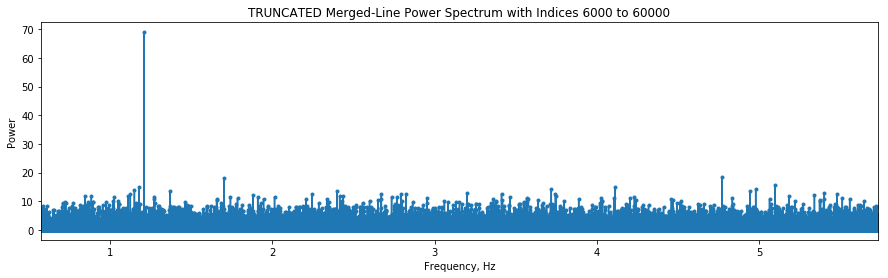

In [24]:
###################This cell is for truncating data and only seeing certain frequencies
mindex =6000
maxdex = 60000#len(frequencies)-1


fig = plt.figure(figsize=(15,4))
plt.plot(frequencies[mindex:maxdex], power_spectrum[mindex:maxdex],ls="solid",marker='.')
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((frequencies[mindex], frequencies[maxdex]))
plt.title("TRUNCATED Merged-Line Power Spectrum with Indices {} to {}".format(mindex, maxdex))
plt.show()

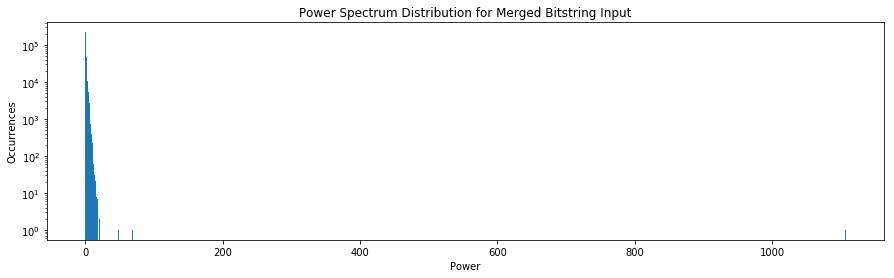

In [25]:
############look at distribution of powers
plt.figure(figsize=(15,4))
plt.hist(power_spectrum, bins = 1000, log=True)
plt.title("Power Spectrum Distribution for Merged Bitstring Input")
plt.xlabel("Power")
plt.ylabel("Occurrences")
plt.show()

